In [1]:
# libraries
import sys; sys.path.insert(0, '..') # if you don't find it here, look one above
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as spio
import pickle
# stored one repo up in my fork of Spykes
from spykes.spykes.plot.neurovis import NeuroVis
from io_utils import *
from plotting_utils import * 

# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")

In [2]:
# base paths/names
sess_names = np.load('sess_names.npy')
sess_name = sess_names[4]

base_path  = 'Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata' 
beh_mat   = 'protocol_info.mat'
spks_mat  = 'ksphy_clusters_foranalysis.mat'


# create paths
sess_path = os.path.join(base_path, sess_name)
beh_path  = os.path.join(sess_path, beh_mat)
spks_path = os.path.join(sess_path, spks_mat)
fig_save_path = os.path.join(os.getcwd(), 'figures', 'neurovis', sess_name)

# load & wrangle
beh_df, spks_dict = load_and_wrangle(beh_path, spks_path, overwrite=True)


C:\Users\brodylab\Documents\GitHub\jbreda_PWM_ephys_analysis\io_utils.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beh_df['hit_hist'][beh_df['hit_hist'].isnull()] = "viol"


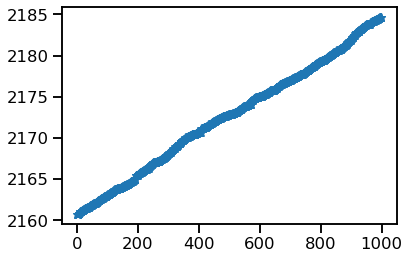

In [46]:
plt.plot(spks_dict['spk_times'][0][79000:80000], '*')

In [6]:
# filter dataframe
beh_df_d2_h = beh_df[(beh_df['delay'] == 2)
       & (beh_df['hit_hist'] == 'hit')]

# deal with masking
bndl_dfs, df_names = deal_with_masking(spks_dict, beh_df_d2_h, sess_path)

Loading existing mask_dict...
Done loading.
ngood, first: 55
ngood, first: 55
ngood, second: 57
ngood, second: 57
ngood, second: 57
ngood, second: 57


In [8]:
# initilaize
events = ['aud1_on']
windows = [[-1000,2300]]
condition = 'correct_side'

# get neurons into NeuroVis objects
neurons = initiate_neurons(spks_dict)

In [12]:
for i in range(len(neurons)):
    print(neurons[i].firingrate)

41.62536763446176
4.445483935980218
7.075451532646395
49.320369732448
2.0342433600549006
2.74375896711459


In [13]:
neuron_rasters = get_neuron_rasters(neurons, events, windows, bndl_dfs, df_names)
neuron_psths = get_neuron_psths(neurons, events, windows, bndl_dfs, df_names, conditions=condition)

In [35]:
((np.sum(neuron_rasters[5][0]['data'][0], axis = 1)))

array([ 0,  0,  7, 14,  8, 12, 16, 13,  3,  2,  8, 10,  5,  2, 22,  6,  8,
       12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0], dtype=int64)

{'event': 'aud1_on',
 'conditions': None,
 'window': [-1000.0, 2300.0],
 'binsize': 50,
 'data': {0: array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=int64)}}

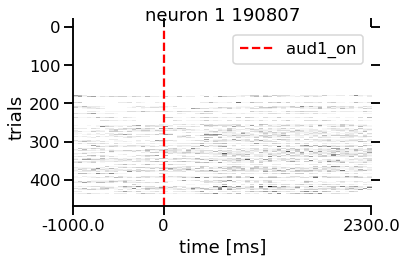

In [50]:
nn = 0
neurons[0].get_raster(event = events[0], df = beh_df, window = windows[0],
                     binsize = 50)